In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from time import sleep
import socket,time,requests
from bs4 import BeautifulSoup
import tkinter as tk

import yfinance as yf
import datetime




In [5]:
ticker='SOKM.IS'
start="2021-01-01"
end=str(datetime.date.today() +datetime.timedelta(days=1))
sokm=yf.download(ticker,start,end)


[*********************100%***********************]  1 of 1 completed


In [6]:
sokm.index=pd.to_datetime(sokm.index)
sokm

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-04,12.670000,13.000000,12.630000,12.990000,12.846131,8130734
2021-01-05,13.080000,13.450000,12.980000,13.180000,13.034028,21723960
2021-01-06,13.290000,13.350000,13.010000,13.040000,12.895577,9501027
2021-01-07,13.080000,13.220000,13.020000,13.080000,12.935135,7231038
2021-01-08,13.200000,14.150000,13.180000,13.990000,13.835056,35307250
...,...,...,...,...,...,...
2023-06-14,30.860001,31.260000,30.040001,30.639999,30.639999,5088918
2023-06-15,30.740000,31.900000,30.740000,31.900000,31.900000,4568659
2023-06-16,32.000000,32.820000,31.700001,32.299999,32.299999,7274382


In [7]:
close=pd.DataFrame(sokm["Close"])

close


,Close
Date,
2021-01-04,12.990000
2021-01-05,13.180000
2021-01-06,13.040000
2021-01-07,13.080000
2021-01-08,13.990000
...,...
2023-06-14,30.639999
2023-06-15,31.900000
2023-06-16,32.299999


In [8]:
rolling_app5=close.rolling(window=5).mean()
rolling_app14=close.rolling(window=14).mean()
rolling_app21=close.rolling(window=21).mean()



In [9]:
MAs=pd.concat([close,rolling_app5,rolling_app14,rolling_app21],axis=1)
MAs.columns=["Close","short","mid","long"]


In [10]:
MAs.dropna(axis=0,inplace=True)
MAs

,Close,short,mid,long
Date,,,,
2021-02-01,13.570000,13.716,13.893571,13.765238
2021-02-02,13.670000,13.604,13.862857,13.797619
2021-02-03,13.750000,13.616,13.856429,13.824762
2021-02-04,13.860000,13.622,13.885000,13.863809
2021-02-05,14.480000,13.866,13.941429,13.930476
...,...,...,...,...
2023-06-14,30.639999,31.096,29.050000,29.114286
2023-06-15,31.900000,31.312,29.391429,29.240000
2023-06-16,32.299999,31.588,29.790000,29.349524


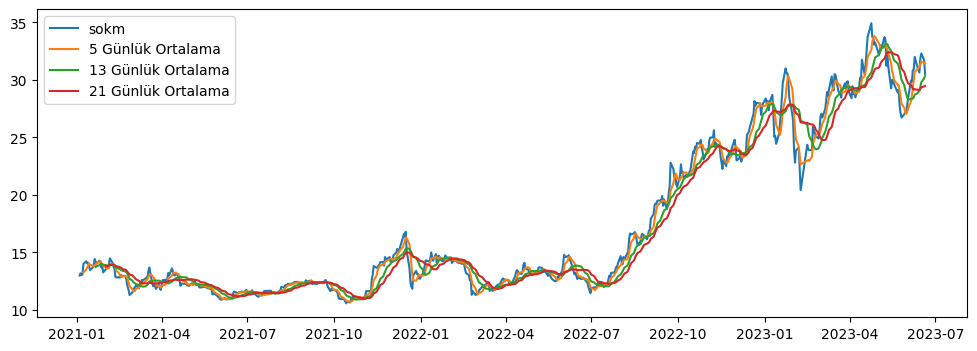

In [40]:
fig,ax=plt.subplots(figsize=(12,4))
ax.plot(close.index,close,label='sokm')
ax.plot(rolling_app5.index,rolling_app5,label='5 Günlük Ortalama')
ax.plot(rolling_app14.index,rolling_app14,label='13 Günlük Ortalama')
ax.plot(rolling_app21.index,rolling_app21,label='21 Günlük Ortalama')
ax.legend(loc='upper left')


In [99]:
def buy_sell_MA(data,opt=50):
    buy_sell=[]
    buy_signal=[]
    sell_signal=[]
    flag=42

    up=data[(np.array(data["short"]-data["mid"])>0) & (np.array(data["short"]-data["long"])>0)]
    down=data[(np.array(data["short"]-data["mid"])<0) & (np.array(data["short"]-data["long"])<0)]
    ups=np.percentile(np.array(up["short"]-up["mid"]),opt)
    downs=np.percentile(np.array(down["short"]-down["long"]),opt)


    for i in range(0,len(data)):
       if (data["short"][i]>data["mid"][i]+ups) & (data["short"][i]>data["long"][i]+ups):
            buy_signal.append(np.nan)
            if flag !=1:
                sell_signal.append(data["Close"][i])
                buy_sell.append(data["Close"][i])
                flag=1
            else:
                sell_signal.append(np.nan)
       elif(data["short"][i]<data["mid"][i]+downs)&(data["short"][i]<data["long"][i]+downs):
            sell_signal.append(np.nan)
            if flag!=0:
                buy_signal.append(data["Close"][i])
                buy_sell.append(-data["Close"][i])
                flag=0
            else:
                buy_signal.append(np.nan)
       else:
            buy_sell.append(np.nan)
            sell_signal.append(np.nan)
            buy_signal.append(np.nan)

    operations=np.array(buy_sell)
    operations=operations[~np.isnan(operations)]

    neg=0
    pos=0

    for i in range(len(operations)):
        if operations[i]<0:
            neg=i
            break
    for i in range(1,len(operations)):
        if operations[-i]>0:
            pos=i-1
            break
    
    PL=np.sum(operations)
    

    
    
    return (buy_signal,sell_signal,PL)





In [100]:
MAs["Buy"]=buy_sell_MA(MAs)[0]
MAs["Sell"]=buy_sell_MA(MAs)[1]

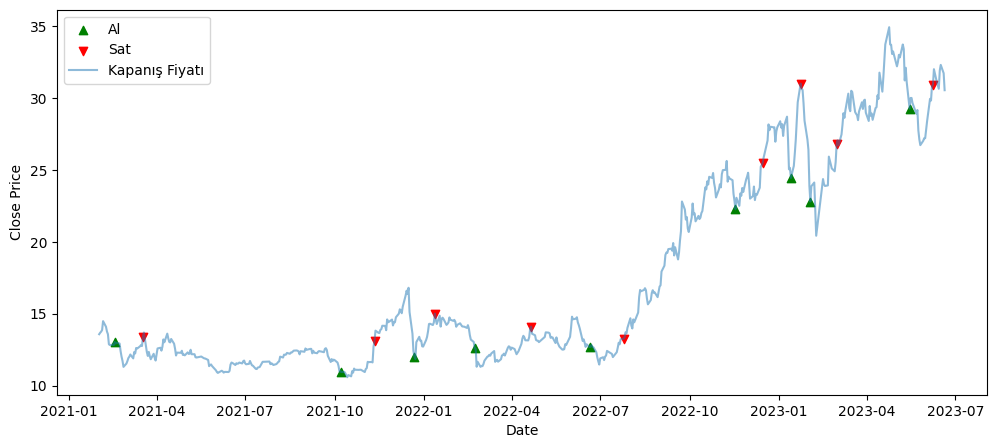

In [101]:
plt.figure(figsize=(12,5))
plt.scatter(MAs.index,MAs["Buy"],color="green",label='Al',marker='^',alpha=1)
plt.scatter(MAs.index,MAs["Sell"],color="red",label='Sat',marker='v',alpha=1)
plt.plot(MAs["Close"],label='Kapanış Fiyatı',alpha=0.5)
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend(loc='upper left')
plt.show()

## Optimizing percentile variable to find best performance

In [89]:
def kar(percentile):
    MAs["Buy"]=buy_sell_MA(MAs,percentile)[0]
    MAs["Sell"]=buy_sell_MA(MAs,percentile)[1]
    al=MAs["Buy"]
    al=al.dropna(axis=0)
    sat=MAs["Sell"]
    sat=sat.dropna(axis=0)
    sat_val=sat.values
    al_val=al.values
    res=[]
    try:

       for i in range(len(al_val)):
          res.append((sat_val[i]/al_val[i]))

    except:
       for i in range(len(sat_val)):
          res.append((sat_val[i]/al_val[i]))

    

    df=pd.DataFrame()
    df["Kar"]=res

    return np.prod(df["Kar"])

In [90]:
percentile=[10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90]



In [91]:
kardf=pd.DataFrame()
kardf["Percentile"]=percentile

In [94]:

for i in range(17):
  kardf.loc[i,1]=kar(percentile[i])

In [96]:
kardf.columns=["Percentile","Performance"]
kardf=kardf.sort_values(by="Performance",ascending=False)
kardf

,Percentile,Performance
9,55,3.373477
8,50,3.251028
16,90,3.152099
14,80,3.142576
13,75,3.050402
11,65,2.876434
7,45,2.800272
10,60,2.635222
6,40,2.578375
15,85,2.531359


In [128]:
MAs["Buy"]=buy_sell_MA(MAs,kardf["Percentile"].values[0])[0]
MAs["Sell"]=buy_sell_MA(MAs,kardf["Percentile"].values[0])[1]

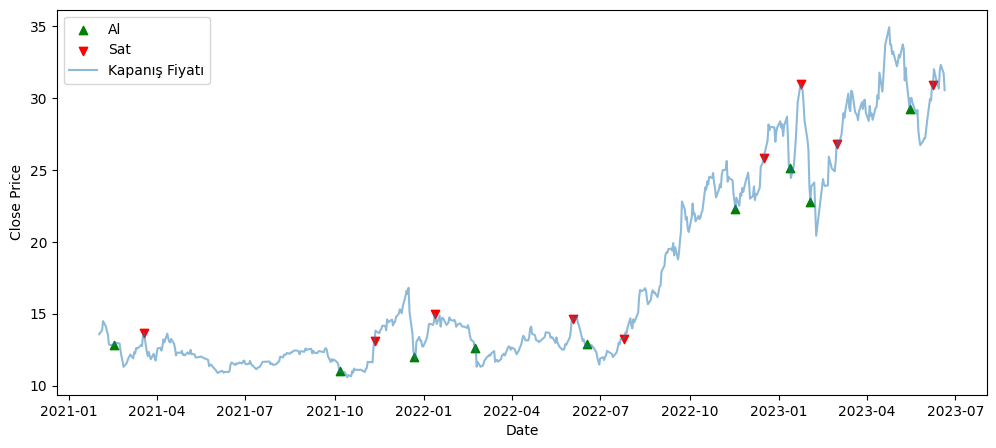

In [129]:
plt.figure(figsize=(12,5))
plt.scatter(MAs.index,MAs["Buy"],color="green",label='Al',marker='^',alpha=1)
plt.scatter(MAs.index,MAs["Sell"],color="red",label='Sat',marker='v',alpha=1)
plt.plot(MAs["Close"],label='Kapanış Fiyatı',alpha=0.5)
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend(loc='upper left')
plt.show()

In [130]:
al=MAs["Buy"]
al=al.dropna(axis=0)
al

Date
2021-02-16    12.820000
2021-10-07    11.010000
2021-12-22    12.010000
2022-02-22    12.590000
2022-06-17    12.870000
2022-11-17    22.260000
2023-01-12    25.139999
2023-02-02    22.799999
2023-05-15    29.260000
Name: Buy, dtype: float64

In [131]:
sat=MAs["Sell"]
sat=sat.dropna(axis=0)
sat


Date
2021-03-19    13.690000
2021-11-11    13.100000
2022-01-12    15.000000
2022-06-03    14.610000
2022-07-25    13.260000
2022-12-16    25.860001
2023-01-23    31.000000
2023-03-01    26.780001
2023-06-08    30.920000
Name: Sell, dtype: float64

In [27]:
del sat["2021-03-17"]

In [132]:
sat_val=sat.values
al_val=al.values


In [133]:
sat_val1=sat_val
sat_val1

array([13.68999958, 13.10000038, 15.        , 14.60999966, 13.26000023,
       25.86000061, 31.        , 26.78000069, 30.92000008])

In [134]:
sat_val1

array([13.68999958, 13.10000038, 15.        , 14.60999966, 13.26000023,
       25.86000061, 31.        , 26.78000069, 30.92000008])

In [135]:
al_val1=al_val
al_val1

array([12.81999969, 11.01000023, 12.01000023, 12.59000015, 12.86999989,
       22.26000023, 25.13999939, 22.79999924, 29.26000023])

In [136]:
res=[]

for i in range(len(al_val1)):
    res.append((sat_val1[i]/al_val1[i]))

In [137]:
df=pd.DataFrame()
df["Kar"]=res
df

,Kar
0,1.067863
1,1.189827
2,1.248959
3,1.160445
4,1.030303
5,1.161725
6,1.233095
7,1.174561
8,1.056733


In [138]:
res0=[100]
for i in range(9):
    res0.append(res0[i]*df["Kar"].loc[i])

df["Eldeki Para"]=res0[1:]
df


,Kar,Eldeki Para
0,1.067863,106.786271
1,1.189827,127.057235
2,1.248959,158.689300
3,1.160445,184.150166
4,1.030303,189.730479
5,1.161725,220.414656
6,1.233095,271.792144
7,1.174561,319.236581
8,1.056733,337.347746


In [139]:
df["Eldeki Para"]=res0[1:]
df

,Kar,Eldeki Para
0,1.067863,106.786271
1,1.189827,127.057235
2,1.248959,158.689300
3,1.160445,184.150166
4,1.030303,189.730479
5,1.161725,220.414656
6,1.233095,271.792144
7,1.174561,319.236581
8,1.056733,337.347746


In [140]:
karlilik=df["Eldeki Para"].iloc[-1]/100
karlilik=(karlilik-1)*100
print("Karlılık oranı %",karlilik)

Karlılık oranı % 237.3477457057876


## Her sat tavsiyesinde satmayıp 2.sat tavsiyesinde satarsak ne olur?(Yani 1 adet sat tavsiyesini pas geçersek)

In [141]:
sat_val2=sat_val[1:9:2]

In [142]:
sat_val2

array([13.10000038, 14.60999966, 25.86000061, 26.78000069])

In [143]:
al_val2=al_val[0:8:2]
al_val2

array([12.81999969, 12.01000023, 12.86999989, 25.13999939])

In [144]:
res1=[]

for i in range(4):
    res1.append((sat_val2[i]/al_val2[i]))

In [145]:
df1=pd.DataFrame()
df1["Kar"]=res1
df1

,Kar
0,1.021841
1,1.216486
2,2.009324
3,1.065235


In [146]:
res2=[100]
for i in range(4):
    res2.append(res2[i]*df1["Kar"].loc[i])




In [147]:
df1["Eldeki Para"]=res2[1:]
df1


,Kar,Eldeki Para
0,1.021841,102.184093
1,1.216486,124.305540
2,2.009324,249.770114
3,1.065235,266.063802


In [148]:
karlilik=df1["Eldeki Para"].iloc[-1]/100
karlilik=(karlilik-1)*100
print("Karlılık oranı %",karlilik)

Karlılık oranı % 166.06380168786447
